In [1]:
import numpy as np
import pandas as pd

import os
import io
import cv2
import json
import pandas as pd
from tqdm import tqdm
from typing import List
from pydantic import BaseModel, Field
from concurrent.futures import ProcessPoolExecutor, as_completed

from google import genai
from google.oauth2.service_account import Credentials
from google.genai import types

# ================== CONFIG ==================
SCOPES = ["https://www.googleapis.com/auth/cloud-platform"]
SERVICE_ACCOUNT_FILE = "/Data2/Arun-UAV/NLP/self-halu-detection/vertix_ai.json"
PROJECT_ID = "hazel-math-472314-h9"
LOCATION = "us-central1"
MODEL_NAME = "gemini-2.5-flash"

COCO_JSON = "/Data2/Arun-UAV/NLP/vision_halu/train_datasets/coco_sample_5000.json"
IMAGE_DIR = "/Data2/Arun-UAV/NLP/vision_halu/train_datasets/poc_5000_coco_images"
OUTPUT_JSON = "/Data2/Arun-UAV/NLP/vision_halu/train_datasets/coco_img_descriptions_parallel.json"

MAX_WORKERS = 64  # Adjust based on CPU count
# ============================================

# ---------- GEMINI CLIENT SETUP -------------
credentials = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
client = genai.Client(
    vertexai=True,
    project=PROJECT_ID,
    location=LOCATION,
    credentials=credentials,
)

In [3]:
data_20k = pd.read_csv("/Data2/Arun-UAV/NLP/vision_halu/haloc/haloc_extension/caption/original_sampled_14k.csv")

In [4]:
def get_prompt(question, ans_1, ans_2):
  prompt = f"""
You are given an **image** and **two captions (descriptions)** related to that image.
Your job is to analyze each caption separately and return **two lists of single words (no phrases)**:

1. **`hallucination_candidates`** — all meaningful words that are semantically important for hallucination detection, belonging to categories like:

   * **objects** (car, tree, person, lamp),
   * **attributes** (red, shiny, tall),
   * **relations** (on, under, behind, next_to),
   * **actions** (running, holding, sitting),
   * **count** (two, many, three),
   * **scene/context** (beach, kitchen, street).
   * **Decision tokens** yes, no, true, false, present, absent, exist, not, visible, correct

   Include only **specific, content-bearing words** that could be visually verifiable or falsifiable from the image.
   Do **not** include stopwords, determiners, or abstract terms.

2. **`hallucinated_words`** — a subset of the above list that are **not visually supported** or are **contradicted** by the image content (i.e., hallucinated terms).

**Inputs:**

<attached image>

caption_pair_1:
Question: {question}
Caption: {ans_1}

caption_pair_2:
Question: {question}
Caption: {ans_2}


**Output format (strict JSON per caption pair):**

```json
{{
  "caption_pair_1": {{
    "hallucination_candidates": ["word1", "word2", ...],
    "hallucinated_words": ["wordX", "wordY", ...]
  }},
  "caption_pair_2": {{
    "hallucination_candidates": ["word1", "word2", ...],
    "hallucinated_words": ["wordX", "wordY", ...]
  }}
}}
```
Note: extract "hallucination_candidates" and "hallucinated_words" from the Answer strictly not from the Question

Ensure both lists contain **only lowercase single words** and are **deduplicated**.
Focus on **important, visually grounded words** — not all tokens.

---
"""
  return prompt

In [17]:
for inx, row in data_20k.iloc[1:].iterrows():
    question = row["prompt"].replace("<image>", "")
    nh_ans  = row["source_text"]
    h_ans = row["hallucinated_text"]
    PROMPT = get_prompt(question, nh_ans, h_ans)
    
    img_path = f"/Data2/Arun-UAV/NLP/vision_halu/visual_genome/VG_100K/{row['image_id']}.jpg" 
    
    image = cv2.imread(img_path)
    
    if image is None:
        print("Image not found")

    _, encoded_img = cv2.imencode(".jpg", image)
    img_bytes = io.BytesIO(encoded_img.tobytes()).getvalue()

    contents = [PROMPT, types.Part.from_bytes(data=img_bytes, mime_type="image/jpeg")]

    structured_config = types.GenerateContentConfig(
        temperature=0,
        top_p=1.0,
        top_k=32,
        candidate_count=1,
        max_output_tokens=65535,
        response_mime_type="application/json",
        thinking_config=types.ThinkingConfig(thinking_budget=1000),
    )

    response = client.models.generate_content(
        model=MODEL_NAME,
        contents=contents,
        config=structured_config,
    )
    break

In [18]:
res = response.candidates[0].content.parts[0].text

In [19]:
print(res)

{
  "caption_pair_1": {
    "hallucination_candidates": [
      "two",
      "boats",
      "water",
      "right",
      "side",
      "dog",
      "background",
      "wall",
      "pole",
      "rack",
      "stand"
    ],
    "hallucinated_words": [
      "stand"
    ]
  },
  "caption_pair_2": {
    "hallucination_candidates": [
      "two",
      "boats",
      "water",
      "right",
      "side",
      "dog",
      "background",
      "wall",
      "pole",
      "rack",
      "stand",
      "bench",
      "left",
      "image",
      "beach"
    ],
    "hallucinated_words": [
      "stand",
      "bench",
      "beach"
    ]
  }
}


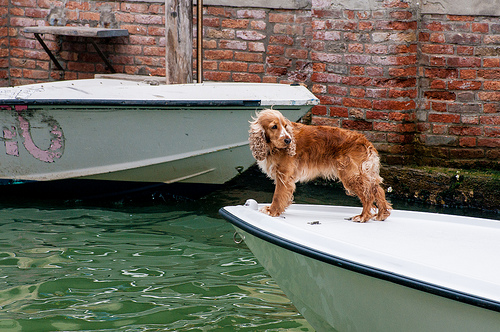

In [11]:
from PIL import Image
Image.open(img_path)

In [12]:
nh_ans

'There are two boats on a water. On the right side boat there is a dog on a boat. We can see in the background wall,pole,rack with stand.'

In [13]:
h_ans

'There are two boats on a water. On the right side boat there is a dog on a boat. We can see in the background wall, pole, rack with stand, and a bench. To the left of the image, there is a beach.'

In [80]:
data = pd.read_csv("/Data2/Arun-UAV/NLP/vision_halu/haloc/visual_genome_25K_gcp_upload_urs.csv")

In [81]:
data

,local_path,gcs_uri,error
0,/Data2/Arun-UAV/NLP/vision_halu/visual_genome/...,gs://train_data_vision/visual_genome_25k/24154...,NaN
1,/Data2/Arun-UAV/NLP/vision_halu/visual_genome/...,gs://train_data_vision/visual_genome_25k/23538...,NaN
2,/Data2/Arun-UAV/NLP/vision_halu/visual_genome/...,gs://train_data_vision/visual_genome_25k/23160...,NaN
3,/Data2/Arun-UAV/NLP/vision_halu/visual_genome/...,gs://train_data_vision/visual_genome_25k/23301...,NaN
4,/Data2/Arun-UAV/NLP/vision_halu/visual_genome/...,gs://train_data_vision/visual_genome_25k/23319...,NaN
...,...,...,...
26217,/Data2/Arun-UAV/NLP/vision_halu/visual_genome/...,gs://train_data_vision/visual_genome_25k/15924...,NaN
26218,/Data2/Arun-UAV/NLP/vision_halu/visual_genome/...,gs://train_data_vision/visual_genome_25k/23899...,NaN
26219,/Data2/Arun-UAV/NLP/vision_halu/visual_genome/...,gs://train_data_vision/visual_genome_25k/23821...,NaN
26220,/Data2/Arun-UAV/NLP/vision_halu/visual_genome/...,gs://train_data_vision/visual_genome_25k/15927...,NaN
